# Tutorial: How to use Qutip for Spin systems

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as q 

## Time independant solutions

qutip is a library with many pre programmed tools to directly apply to your system. In the following we want to directly apply it to the Hamiltonian for a single spin system.

$H = \omega_s S_z + \Omega_1 \cos(\omega t) S_x$

This Hamiltonian can be easily solved with rotating wave approximation ($\omega_s = \omega + \Delta$) to:

$H = \Delta S_z + \frac{\Omega_1}{2} S_x$

### Rabi Oscillations Spin 1/2

Text(0.5, 0, 'time')

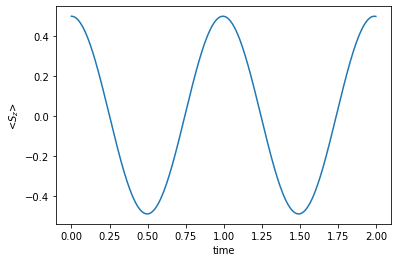

In [5]:
#Define the operators 1/2
sz = q.sigmaz() * 0.5
sx = q.sigmax() * 0.5
sy = q.sigmay() * 0.5


#Physical frequencies
Omega = 1
Omega *= 2 * np.pi
Delta = 0.1 * 2 * np.pi

# NV hamiltonian
H0 = Delta * sz + Omega * sx 


#simulation parameters
time_x=2
npoints = 500
t = np.linspace(0, time_x, npoints)

#initial state - rho
phi = q.basis(2,0)
rho_nv = phi*phi.dag()

#solve evolution
resultat = []
resultat.append(q.mesolve(H=H0, rho0=rho_nv, tlist=t, 
                          c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))

result = q.mesolve(H=H0, rho0=rho_nv, tlist=t) 

#plot expectation value

plt.plot(t,q.expect(result.states, sz))

plt.ylabel('<$S_z$>')
plt.xlabel('time')

### ODMR for NV center

The NV Hamiltonian is given by: \
\
$H = \omega_e S_z + \omega_n I_z + A_{zz} S_z I_z $\
\
when applying a probe field ($\Omega S_x \sin(\omega t)$) we get in the rotating frame (RWA): \
\
$H = \Delta S_z + \omega_n I_z + A_{zz} S_z I_z + \Omega S_x \newline$

Text(0.5, 0, 'freq')

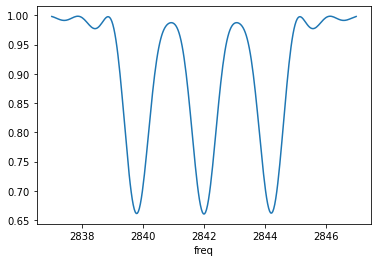

In [130]:
Azz=2.2 * 2 * np.pi #MHz
B0=1.0 #mT
bi = 2.e-3 * B0 *2 * np.pi

D = 2.87e3
bs = 28 * B0
ws = D - bs

Omega = 2 * np.pi * 0.25

time_x= 1
npoints = 500
t = np.linspace(0, time_x, npoints)

#NV operators
#electron reduced as spin 1/2
sz = q.tensor(q.sigmaz()*0.5,q.qeye(3))
sx = q.tensor(q.sigmax()*0.5,q.qeye(3))
sy = q.tensor(q.sigmay()*0.5,q.qeye(3))

#nuclear as spin 1
iz = q.tensor(q.qeye(2),q.spin_Jz(1))
ix = q.tensor(q.qeye(2),q.spin_Jx(1))
iy = q.tensor(q.qeye(2),q.spin_Jy(1))


#initialize density matrix
phi =q.basis(2,0)
rho_nv = phi*phi.dag()


#Nuclear initial pure state
rho_nuclear = q.thermal_dm(3, 1000)
rho_total = q.tensor(rho_nv,rho_nuclear)

odmr=[]

for k,Delta in enumerate(np.linspace(-5,5,300)):
    
    D = 2.87e3
    bs = 28 * B0
    ws = D - bs + Delta
    
    Delta = Delta * 2 * np.pi
    
    H = Delta * sz + Omega * sx + Azz * sz * iz + bi * iz
    
    result = q.mesolve(H=H, rho0=rho_total, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000))
    contrast = q.expect(result.states, q.tensor(q.sigmaz(),q.qeye(3)))[-1]
    freq = ws
    odmr.append([freq,contrast])
    
odmr = np.asarray(odmr).transpose()
plt.plot(odmr[0],odmr[1])
plt.xlabel('freq')

### Flip-Flop Interaction (Hartmann-Hahn)

The Hamiltonian is:\
\
$H = (\Omega + \Delta) S_x + \omega_i I_z + A_{zx} S_z I_x$,\
\
where $\Omega = \omega_i$ is equal to the Hartmann Hahn condition


#### Hartmann Hahn in Resoannce

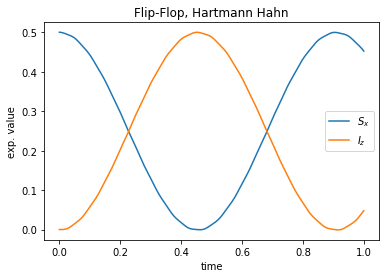

In [148]:
Azx=0.2 * 2 * np.pi #MHz
B0=1.0 #mT
bi = 10 * 2 * np.pi #MHz

Omega = 2 * np.pi * 10

time_x= 1
npoints = 500
t = np.linspace(0, time_x, npoints)

#NV operators
#electron reduced as spin 1/2
sz = q.tensor(q.sigmaz()*0.5,q.qeye(2))
sx = q.tensor(q.sigmax()*0.5,q.qeye(2))
sy = q.tensor(q.sigmay()*0.5,q.qeye(2))

#nuclear as spin 1
iz = q.tensor(q.qeye(2),q.spin_Jz(0.5))
ix = q.tensor(q.qeye(2),q.spin_Jx(0.5))
iy = q.tensor(q.qeye(2),q.spin_Jy(0.5))

#initialize density matrix
phi = (q.basis(2,0) + q.basis(2,1))/np.sqrt(2)
rho_nv = phi*phi.dag()

#Nuclear initial pure state
rho_nuclear = q.thermal_dm(2, 1000)
rho_total = q.tensor(rho_nv,rho_nuclear)

#perfect flip-flop interaction
Delta = 0
H = (Delta + Omega) * sx + Azz * sz * ix + Omega * iz

resultat = []
resultat.append(q.mesolve(H=H, rho0=rho_total, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))    

plt.title('Flip-Flop, Hartmann Hahn')
plt.plot(t,q.expect(resultat[0].states, sx),label='$S_x$')
plt.plot(t,q.expect(resultat[0].states, iz),label='$I_z$')
plt.xlabel('time')
plt.ylabel('exp. value')
plt.legend()

#### Hartmann Hahn outside of resonance

Text(0.5, 0, 'off resonance')

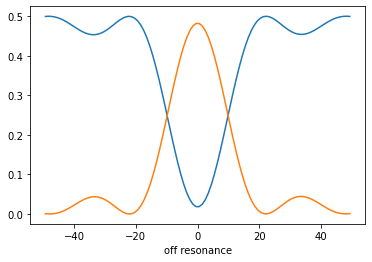

In [160]:
time_x= 0.4
npoints = 500
t = np.linspace(0, time_x, npoints)

flip_flop = []
for k,Delta in enumerate(np.linspace(-5,5,100)):
    
    Delta = Delta * 2 * np.pi
    H = (Delta + Omega) * sx + Azz * sz * ix + Omega * iz
    result= q.mesolve(H=H, rho0=rho_total, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000))
    contrast1 = q.expect(result.states, sx)[-1]
    contrast2 = q.expect(result.states, iz)[-1]
    freq = Delta / 2 * np.pi
    flip_flop.append([freq,contrast1,contrast2])
    
flip_flop = np.asarray(flip_flop).transpose()
plt.plot(flip_flop[0],flip_flop[1],label='$S_x$')
plt.plot(flip_flop[0],flip_flop[2],label='$I_z$')
plt.xlabel('off resonance')